# Работа с Excel

Материалы:
* Макрушин С.В. Лекция 7: Работа с Excel
* https://docs.xlwings.org/en/stable/quickstart.html
* https://nbviewer.jupyter.org/github/pybokeh/jupyter_notebooks/blob/master/xlwings/Excel_Formatting.ipynb#search_text


## Задачи для совместного разбора

1. На листе "Рецептура" файла `себестоимостьА_в1.xlsx` для области "Пшеничный хлеб" рассчитать себестоимость всех видов продукции.

2. Результаты расчетов 1.1 сохранить в отдельном столбце области "Пшеничный хлеб"

3. Приблизить форматирование столбца, добавленного в задаче 2 к оформлению всей области.

4. Выполнить 3 с помощью "протягиваемых" формул.

## Лабораторная работа 4.1

In [64]:
import pandas as pd
import xlwings as xw
import csv

In [66]:
!pip show xlwings

Name: xlwings
Version: 0.31.4
Summary: Make Excel fly: Interact with Excel from Python and vice versa.
Home-page: https://www.xlwings.org
Author: Zoomer Analytics LLC
Author-email: felix.zumstein@zoomeranalytics.com
License: BSD 3-clause
Location: /opt/anaconda3/lib/python3.12/site-packages
Requires: appscript, psutil
Required-by: 


In [68]:
!xlwings addin install

xlwings version: 0.31.4


1. Загрузите данные из файлов `reviews_sample.csv` (__ЛР2__) и `recipes_sample.csv` (__ЛР5__) в виде `pd.DataFrame`. Обратите внимание на корректное считывание столбца(ов) с индексами. Оставьте в таблице с рецептами следующие столбцы: `id`, `name`, `minutes`, `submitted`, `description`, `n_ingredients`

In [71]:
reviews = pd.read_csv("reviews_sample.csv", index_col=0)
reviews.head()

,user_id,recipe_id,date,rating,review
370476,21752,57993,2003-05-01,5,Last week whole sides of frozen salmon fillet ...
624300,431813,142201,2007-09-16,5,So simple and so tasty! I used a yellow capsi...
187037,400708,252013,2008-01-10,4,"Very nice breakfast HH, easy to make and yummy..."
706134,2001852463,404716,2017-12-11,5,These are a favorite for the holidays and so e...
312179,95810,129396,2008-03-14,5,Excellent soup! The tomato flavor is just gre...


In [73]:
recipes = pd.read_csv("recipes_sample.csv")[['id','name', 'minutes', 'submitted', 'description', 'n_ingredients']]
recipes.head()

,id,name,minutes,submitted,description,n_ingredients
0,44123,george s at the cove black bean soup,90,2002-10-25,an original recipe created by chef scott meska...,18.0
1,67664,healthy for them yogurt popsicles,10,2003-07-26,my children and their friends ask for my homem...,NaN
2,38798,i can t believe it s spinach,30,2002-08-29,"these were so go, it surprised even me.",8.0
3,35173,italian gut busters,45,2002-07-27,my sister-in-law made these for us at a family...,NaN
4,84797,love is in the air beef fondue sauces,25,2004-02-23,i think a fondue is a very romantic casual din...,NaN


2. Случайным образом выберите 5% строк из каждой таблицы и сохраните две таблицы на разные листы в один файл `recipes.xlsx`. Дайте листам названия "Рецепты" и "Отзывы", соответствующие содержанию таблиц. 

In [76]:
recipes_sample = recipes.sample(frac=0.05)
reviews_sample = reviews.sample(frac=0.05)


with pd.ExcelWriter("recipes.xlsx", engine="xlsxwriter") as writer:
    recipes_sample.to_excel(writer, sheet_name="Рецепты", index=False)
    reviews_sample.to_excel(writer, sheet_name="Отзывы", index=False)

3. Используя `xlwings`, добавьте на лист `Рецепты` столбец `seconds_assign`, показывающий время выполнения рецепта в секундах. Выполните задание при помощи присваивания массива значений диапазону ячеек.

In [79]:
wb = xw.Book("recipes.xlsx")
ws = wb.sheets["Рецепты"]

In [81]:
data = ws.range("A1").expand().value

header = data[0]
minutes_col_idx = header.index('minutes') 

seconds_assign = []
for row in data[1:]:
    minutes = row[minutes_col_idx]
    seconds_assign.append([minutes * 60])

ws.range(f"{chr(65 + len(data[0]))}1").value = "seconds_assign" 
ws.range(f"{chr(65 + len(data[0]))}2").value = seconds_assign
ws.autofit()

wb.save()

4. Используя `xlwings`, добавьте на лист `Рецепты` столбец `seconds_formula`, показывающий время выполнения рецепта в секундах. Выполните задание при помощи формул Excel.

In [84]:
data_range = ws.range("A1").expand()
data = data_range.value

header = data[0]
minutes_col_idx = header.index('minutes')
minutes_col_letter = chr(65 + minutes_col_idx)

new_col_letter = chr(65 + len(header))

ws.range(f"{new_col_letter}1").value = "seconds_formula"

first_data_row = 2  
last_row = data_range.last_cell.row  

ws.range(f"{new_col_letter}{first_data_row}:{new_col_letter}{last_row}").formula = f"={minutes_col_letter}{first_data_row}*60"

ws.autofit()
wb.save()

5. Сделайте названия всех добавленных столбцов полужирными и выровняйте по центру ячейки. - **Skip**

6. Раскрасьте ячейки столбца `minutes` в соответствии со следующим правилом: если рецепт выполняется быстрее 5 минут, то цвет - зеленый; от 5 до 10 минут - жёлтый; и больше 10 - красный.

In [88]:
data = ws.range("A1").expand().value
minutes_col_idx = header.index('minutes')
minutes_col_letter = chr(65 + minutes_col_idx)
first_data_row = 2
last_row = ws.range(f"{minutes_col_letter}1").end('down').row

colors = {
    'green': (0, 176, 80),    # Быстрее 5 минут
    'yellow': (255, 255, 0),   # 5-10 минут
    'red': (255, 0, 0)         # Больше 10 минут
}


for row in range(first_data_row, last_row + 1):
    cell = ws.range(f"{minutes_col_letter}{row}")
    minutes = cell.value
    
    if minutes is not None:
        if minutes < 5:
            cell.color = colors['green']
        elif 5 <= minutes <= 10:
            cell.color = colors['yellow']
        else:
            cell.color = colors['red']

ws.autofit()
wb.save()

7. Добавьте на лист `Рецепты`  столбец `n_reviews`, содержащий кол-во отзывов для этого рецепта. Выполните задание при помощи формул Excel.  - **Skip**

## Лабораторная работа 4.2

8. Напишите функцию `validate()`, которая проверяет соответствие всех строк из листа `Отзывы` следующим правилам:
    * Рейтинг - это число от 0 до 5 включительно
    * Соответствующий рецепт имеется на листе `Рецепты`
    
В случае несоответствия этим правилам, выделите строку красным цветом

In [93]:
def validate(wb):
    ws_reviews = wb.sheets['Отзывы']
    ws_recipes = wb.sheets['Рецепты']

    recipe_ids = ws_recipes.range('A1').expand('down').value
    
    if isinstance(recipe_ids, (str, int, float)):
        recipe_ids = [recipe_ids]
    else:
        recipe_ids = [str(id) for id in recipe_ids]

    reviews_range = ws_reviews.range('A2').expand('table')
    reviews_data = reviews_range.value

    header = ws_reviews.range('A1').expand('right').value
    try:
        recipe_col = header.index("recipe_id")
        rating_col = header.index("rating")
    except ValueError:
        print("Не найдены нужные столбцы: 'recipe_id' и 'rating'")
        return

    for i, row in enumerate(reviews_data):
        row_valid = True

        # Проверка рейтинга
        try:
            rating = float(row[rating_col])
            if not (0 <= rating <= 5):
                row_valid = False
        except (ValueError, TypeError):
            row_valid = False

        # Проверка рецепта по id
        try:
            recipe_id = str(row[recipe_col])
            if recipe_id not in recipe_ids:
                row_valid = False
        except (ValueError, TypeError):
            row_valid = False

    
        if not row_valid:
            reviews_range.rows[i].color = (255, 0, 0)
        else:
            reviews_range.rows[i].color = None

In [95]:
validate(wb)

9. В файле `recipes_model.csv` находится модель данных предметной области "рецепты". При помощи пакета `csv` считайте эти данные. При помощи пакета `xlwings` запишите данные на лист `Модель` книги `recipes_model.xlsx`, начиная с ячейки `A2`, не используя циклы. Сделайте скриншот текущего состояния листа и прикрепите в ячейку ноутбука. 

In [129]:
with open('recipes_model.csv') as file:
    csv_reader = csv.reader(file, delimiter='\t')
    data = list(csv_reader)

In [131]:
try:
    wb = xw.Book('recipes_model.xlsx') 
except FileNotFoundError:
    wb = xw.Book()
    wb.save('recipes_model.xlsx')

if 'Модель' not in [sheet.name for sheet in wb.sheets]:
    wb.sheets.add('Модель')  
sheet = wb.sheets['Модель']
sheet.range('A2').value = data 


wb.save()

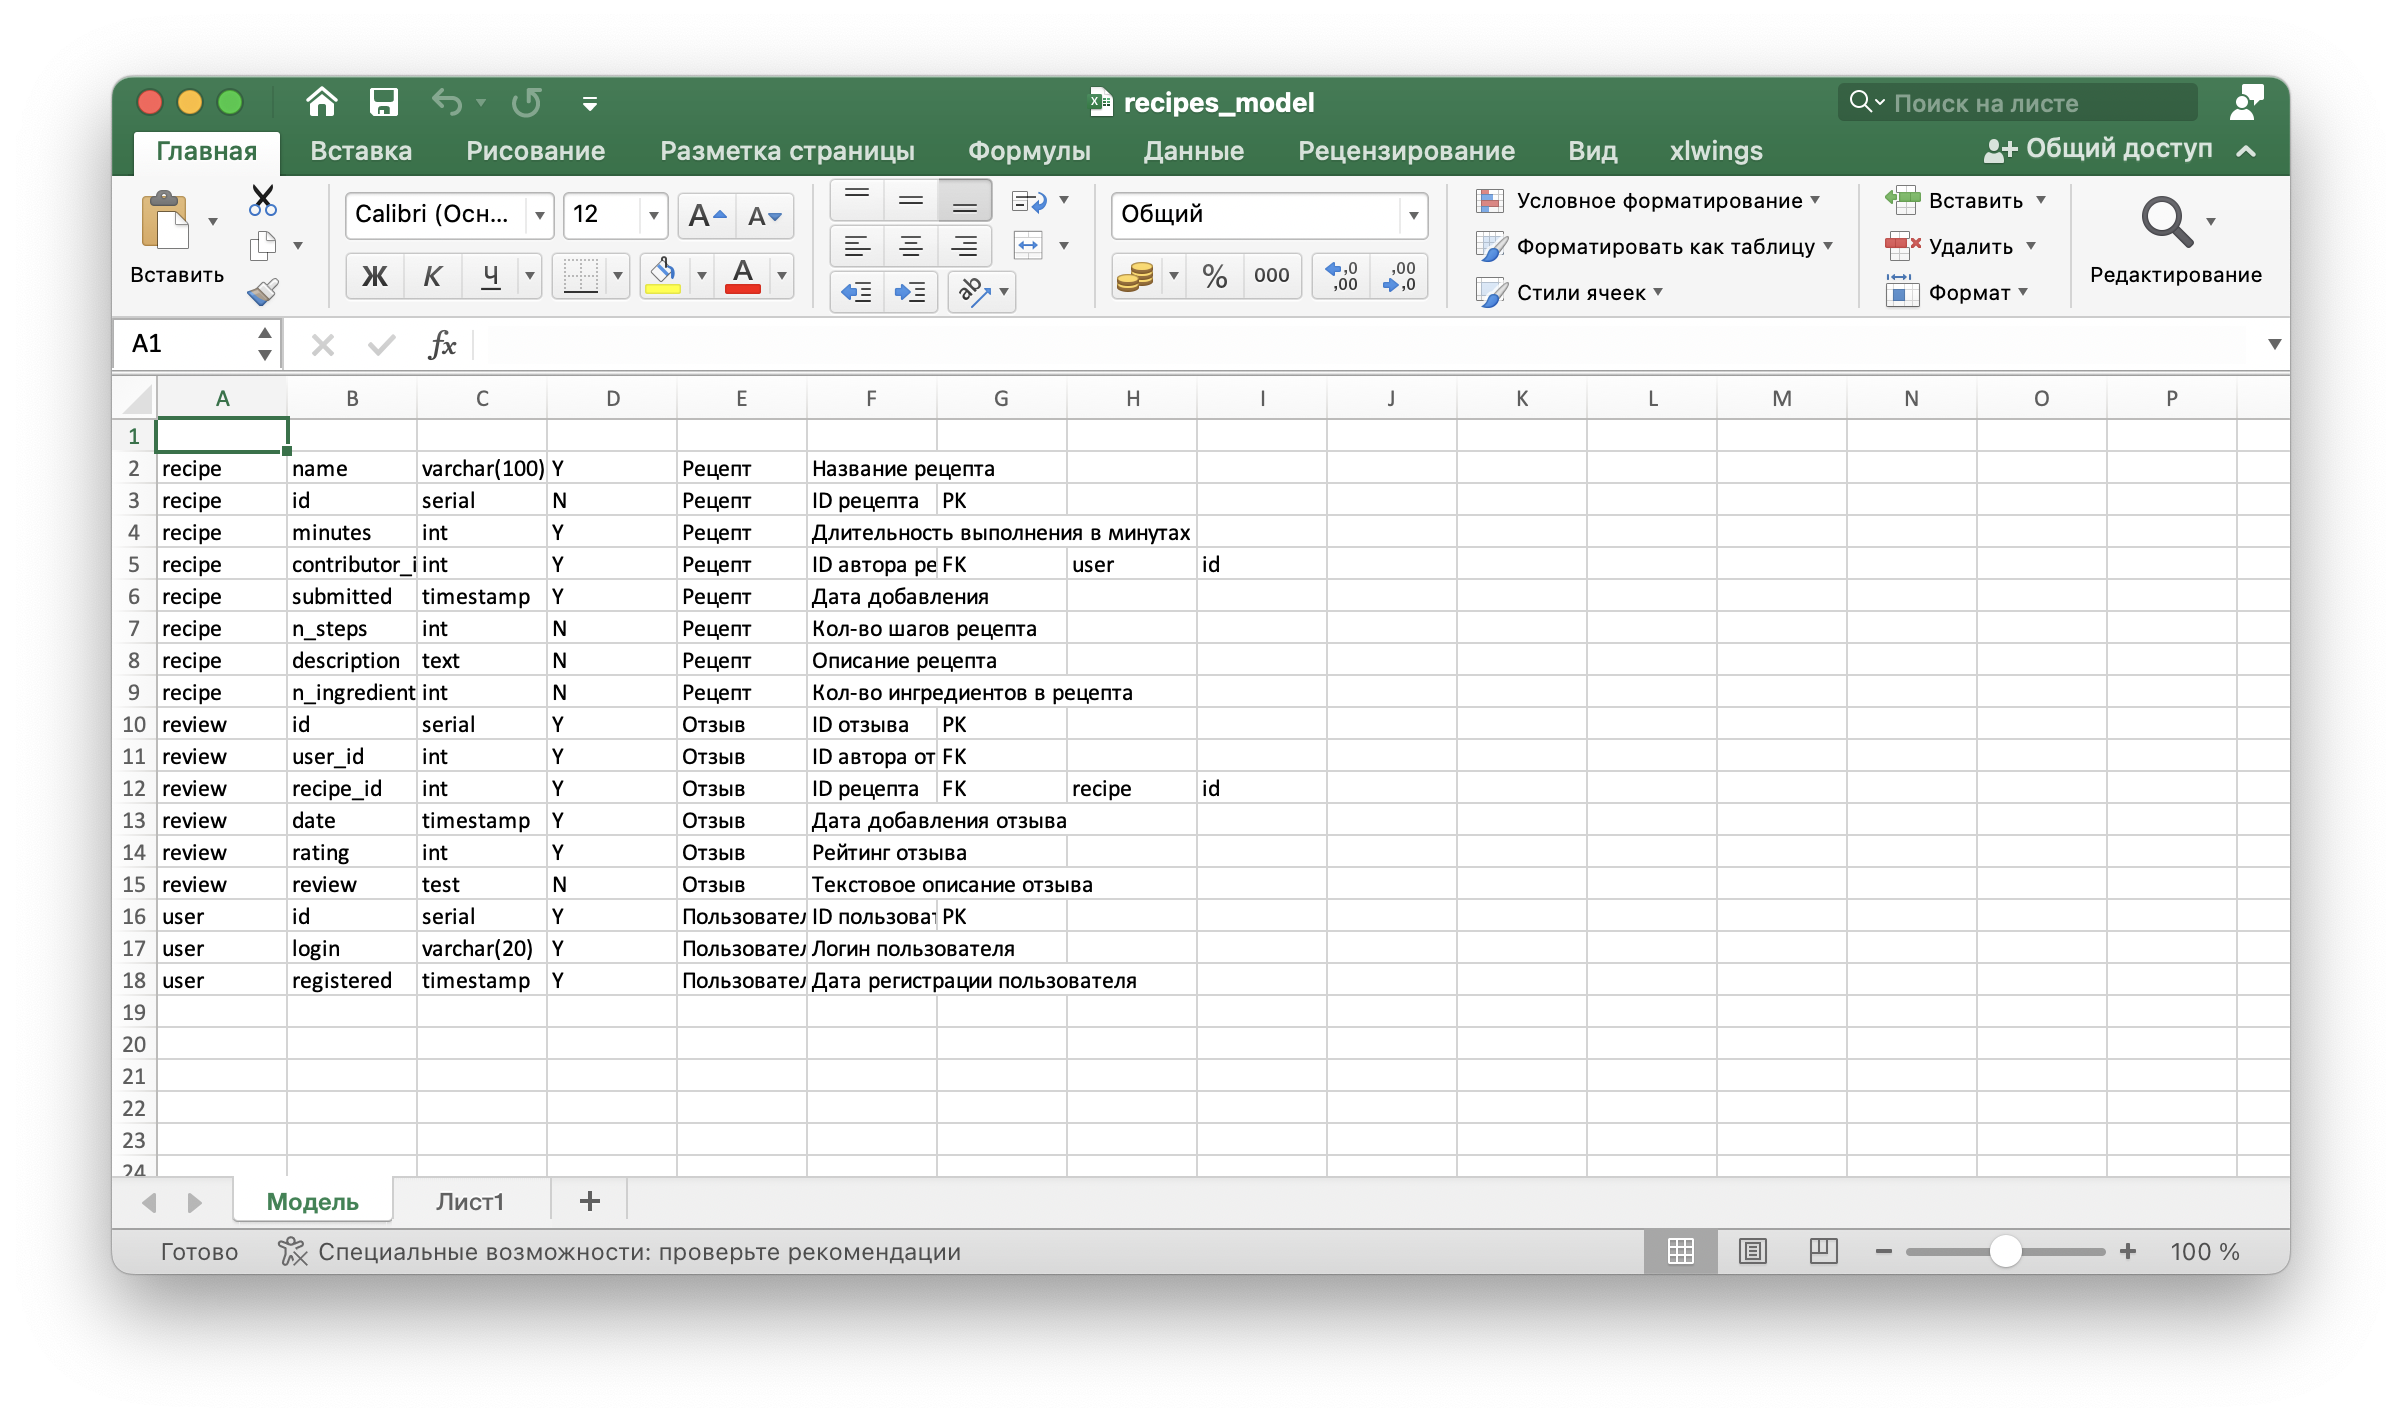

10. При помощи пакета `xlwings` добавьте в столбец J формулу для описания столбца на языке SQL. Формула должна реализовывать следующую логику:

    1\. в начале строки идут значения из столбцов В и C (значение столбца С приведено к верхнему регистру), разделенные пробелом
    
    2\. далее идут слова на основе столбца "Ключ"
        2.1 если в столбце "Ключ" указано значение "PK", то дальше через пробел идет ключевое слово "PRIMARY KEY"
        2.2 если в столбце "Ключ" указано значение "FK", то дальше через пробел идет ключевое слово "REFERENCES", затем значения столбцов H и I в формате "название_таблицы(название_столбца)"
        
    3\. если в столбце "Обязательно к заполнению" указано значение "Y" и в столбце "Ключ" указано не "PK", то дальше через пробел идет ключевое слово "NOT NULL".

Заполните этой формулой необходимое количество строк, используя "протягивание". Количество строк для протягивания определите на основе данных.

Сделайте скриншот текущего состояния листа и прикрепите в ячейку ноутбука. - **Skip**

11. При помощи пакета `xlwings` измените стилизацию листа `Модель`.
* для заголовков добавьте заливку цвета `00ccff`
* примените автоподбор ширины столбца;
* сделайте шрифт заголовков полужирным;
* добавьте таблице автофильтр.

Сделайте скриншот текущего состояния листа и прикрепите в ячейку ноутбука.

In [136]:
wb = xw.Book("recipes_model.xlsx")
sheet = wb.sheets['Модель']


header_range = sheet.range('A2').expand('right') 
header_range.color = (0, 204, 255)  # RGB для 00ccff

header_range.font.bold = True

sheet["A1"].api.autofilter_range()

sheet.autofit('c')

wb.save()

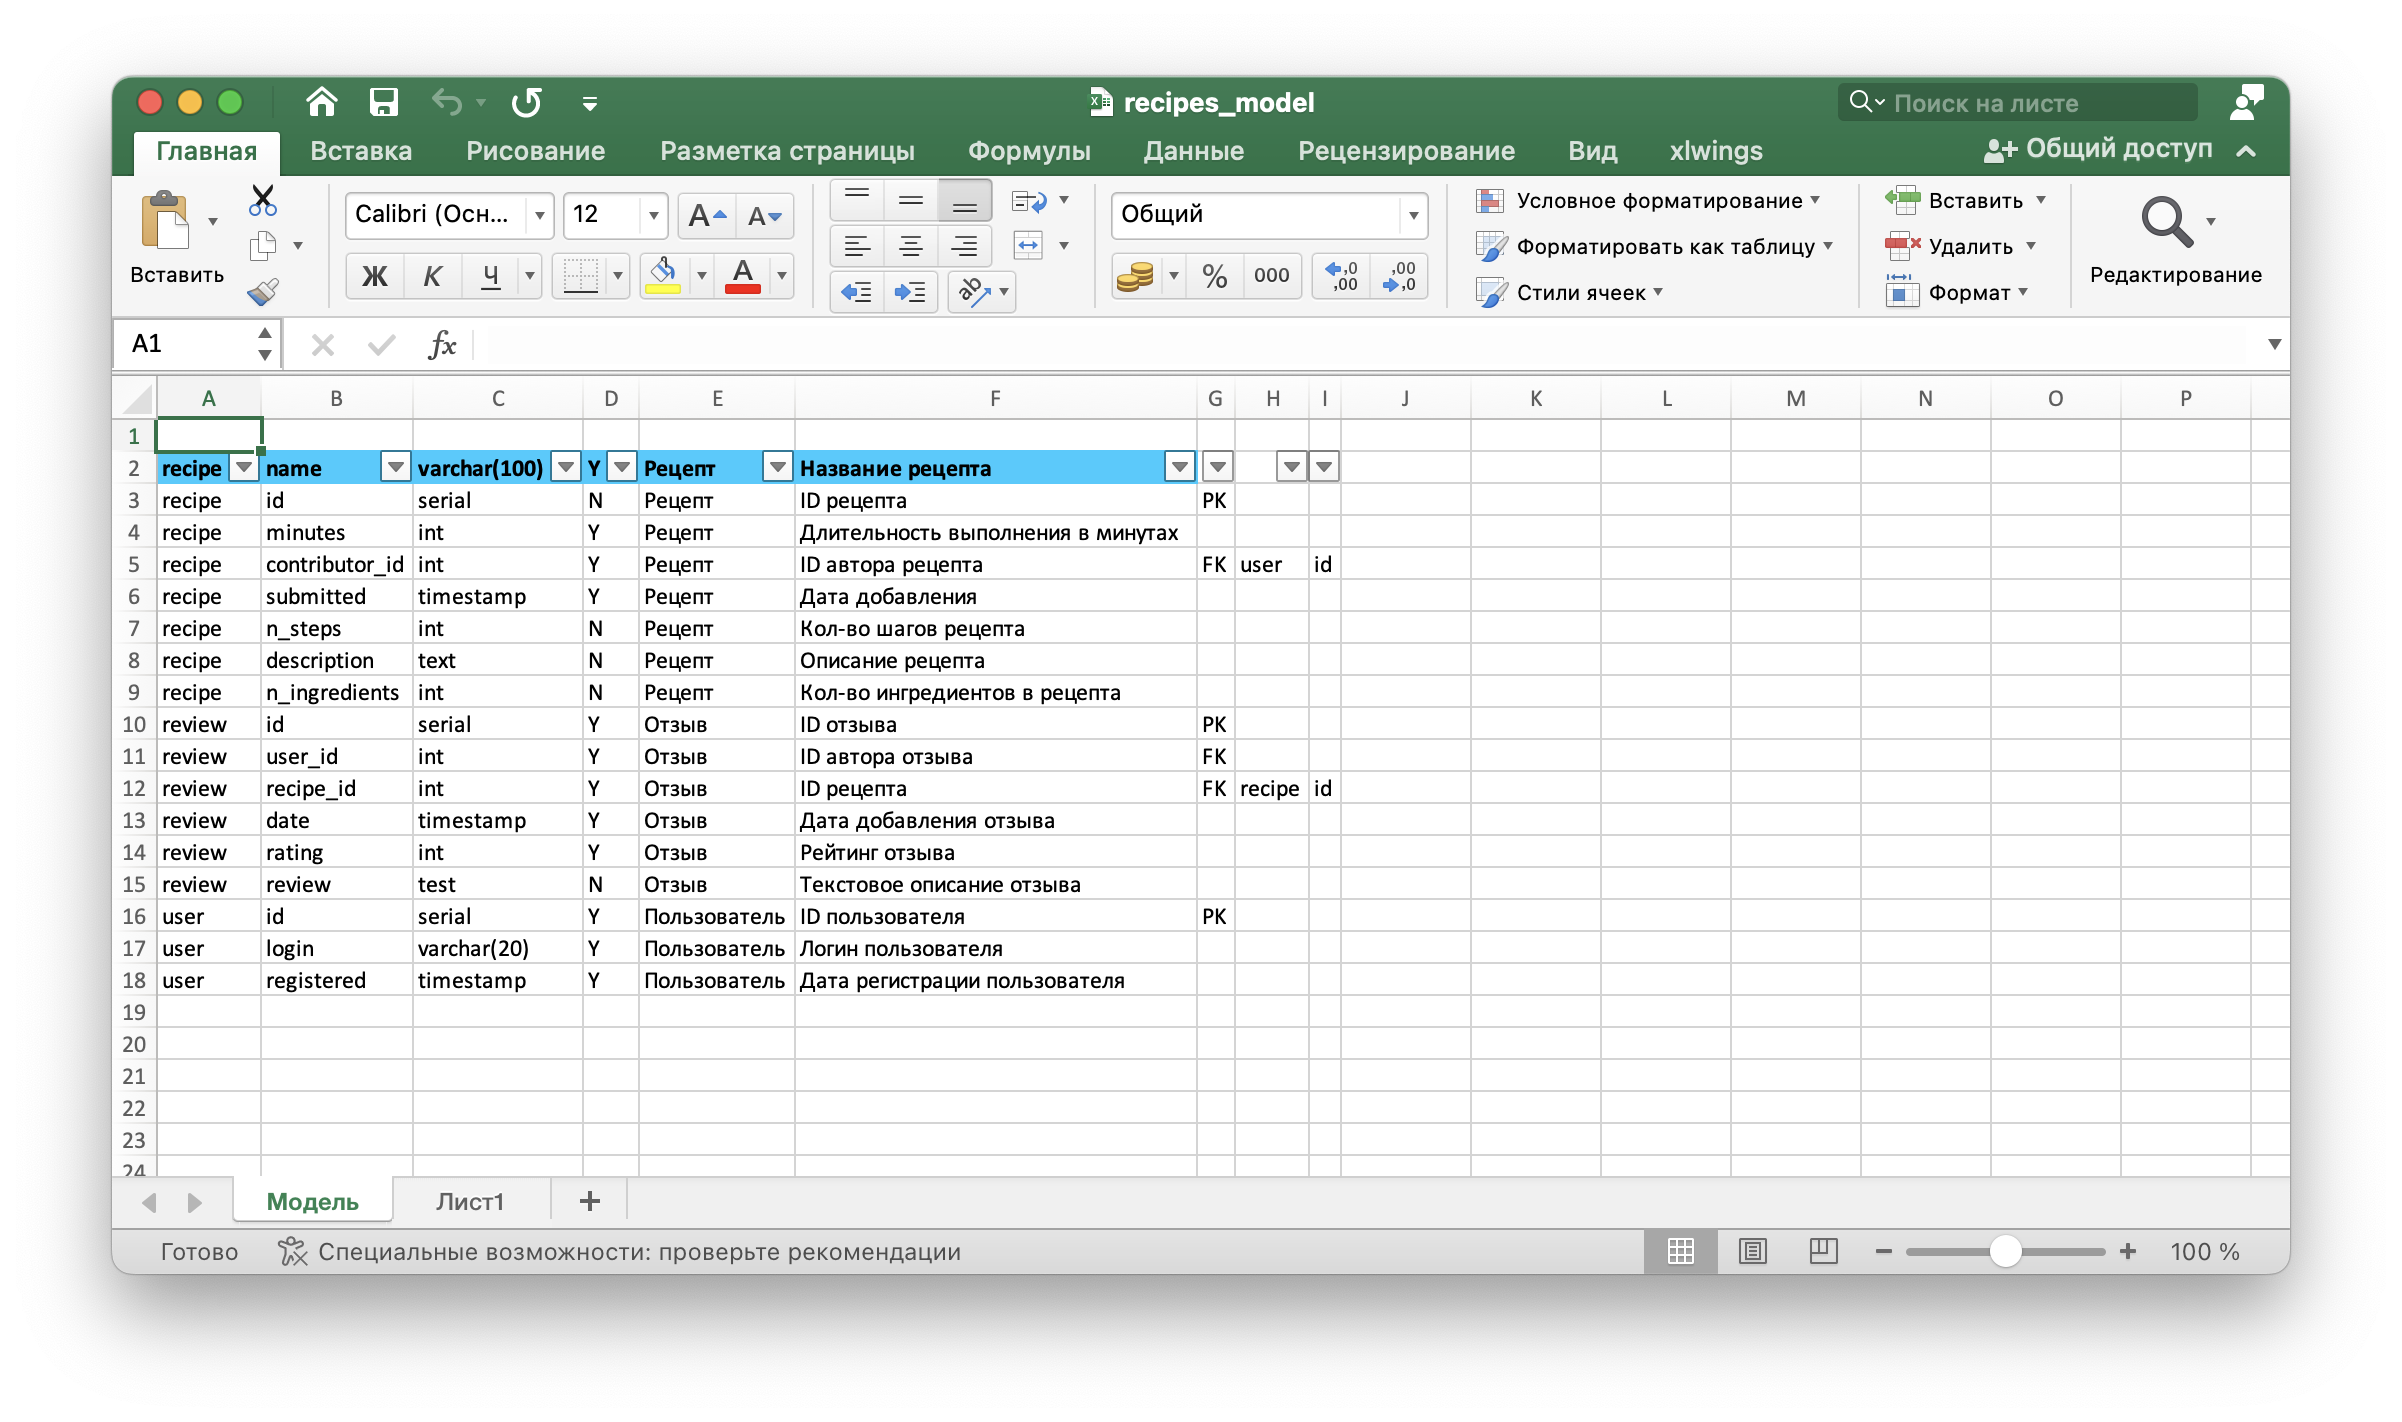

12. Посчитайте количество атрибутов для каждой из сущностей. Создайте лист `Статистика` и запишите в него результат группировки, начиная с ячейки "А1". Визуализируйте полученный результат при помощи столбчатой диаграммы. Сохраните полученную визуализацию на лист `Статистика`, начиная с ячейки "E2".  Сделайте скриншот листа `Статистика` и прикрепите в ячейку ноутбука.

* Вы можете воспользоваться методами для визуализации, которые поставляются вместе с объектами `pandas` (см. https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot) - **Skip**